In [13]:
from ultralytics import YOLO

from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import supervision as sv

In [14]:
detector = YOLO(
    r"/mnt/c/My storage/Python projects/MLBox/scripts/train/2024-12-17-yolov8seg-1024/train/weights/best.pt"
)
classifier = YOLO(
    r"/mnt/c/My storage/Python projects/MLBox/scripts/train/2024-12-18-yolov8s-cls/train2/weights/best.pt"
)

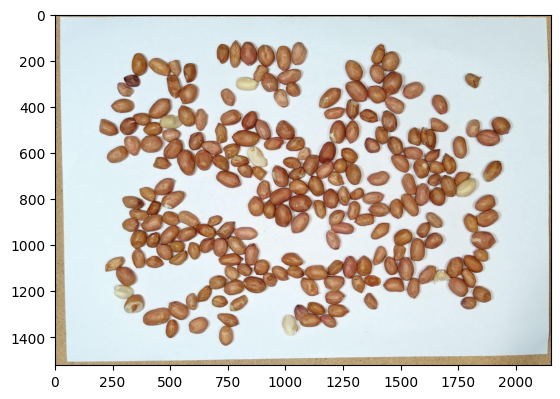

In [15]:
image = Image.open(
    r"/mnt/c/My storage/Python projects/MLBox/tmp/peanuts/output/preprocessing_0.jpg"
).convert("RGB")
plt.imshow(image)
plt.show()

In [16]:
yolo_detections = detector.predict(np.array(image), imgsz=1024, conf=0.85)
detections = sv.Detections.from_ultralytics(yolo_detections[0])


0: 736x1024 212 peanuts, 411.8ms
Speed: 8.2ms preprocess, 411.8ms inference, 292.2ms postprocess per image at shape (1, 3, 736, 1024)


In [17]:
print(yolo_detections[0])

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'peanut'}
obb: None
orig_img: array([[[179, 156, 115],
        [172, 149, 108],
        [171, 148, 107],
        ...,
        [175, 149, 100],
        [172, 146,  97],
        [184, 158, 109]],

       [[176, 153, 112],
        [175, 152, 111],
        [178, 155, 114],
        ...,
        [178, 152, 103],
        [175, 149, 100],
        [187, 161, 112]],

       [[173, 150, 109],
        [176, 153, 112],
        [182, 159, 118],
        ...,
        [181, 155, 106],
        [178, 152, 103],
        [187, 161, 112]],

       ...,

       [[187, 164, 122],
        [188, 165, 123],
        [187, 164, 122],
        ...,
        [189, 162, 117],
        [185, 158, 113],
        [190, 163, 118]],

       [[178, 155, 113],
        [180, 157, 115],
        [183, 160, 118],
        ...,
        [179, 155, 107],
   

In [18]:
crops = []
for i in range(len(detections)):
    xmin, ymin, xmax, ymax = detections.xyxy[i]
    crop = image.crop((xmin, ymin, xmax, ymax))
    crops.append(crop)

classifications = classifier.predict(crops, imgsz=128, conf=0.66, verbose=False)
indices_0 = np.where(np.array([c.probs.top1 in [0] for c in classifications]))[0]
indices_1 = np.where(np.array([c.probs.top1 in [1] for c in classifications]))[0]
indices_2 = np.where(np.array([c.probs.top1 in [2] for c in classifications]))[0]


print(f"0 = {len(indices_0)}  1 = {len(indices_1)}  2 = {len(indices_2)}")

0 = 203  1 = 2  2 = 7


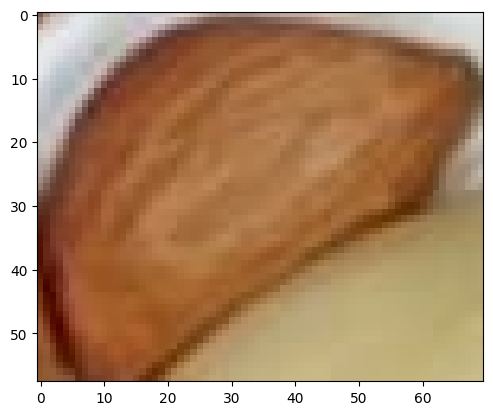

In [19]:
det_i = indices_0[190]

xmin, ymin, xmax, ymax = map(int, detections.xyxy[det_i])
mask = detections.mask[det_i]

crop = image.crop((xmin, ymin, xmax, ymax))
mask = mask[ymin:ymax, xmin:xmax]

plt.imshow(crop)
plt.show()

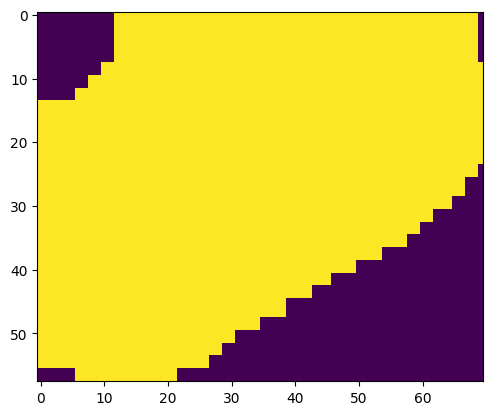

In [20]:
mask_resized = cv2.resize(mask.astype(np.uint8), (crop.width, crop.height))
mask_colored = cv2.applyColorMap(mask_resized * 255, cv2.COLORMAP_JET)
mask_colored = cv2.cvtColor(mask_colored, cv2.COLOR_BGR2RGB)

crop_np = np.array(crop)
overlay = cv2.addWeighted(crop_np, 1, mask_colored, 0.5, 0)

plt.imshow(mask_resized)
plt.show()

In [21]:
print(mask.shape)
print(mask_resized.shape)

(58, 70)
(58, 70)


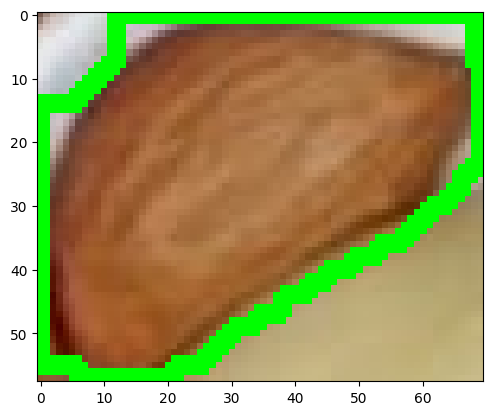

In [22]:
# Convert boolean mask to uint8
mask_uint8 = mask.astype(np.uint8)

# Find contours
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the image
contour_image = cv2.drawContours(np.array(crop), contours, 0, (0, 255, 0), 2)

# Display the image with contours
plt.imshow(contour_image)
plt.show()

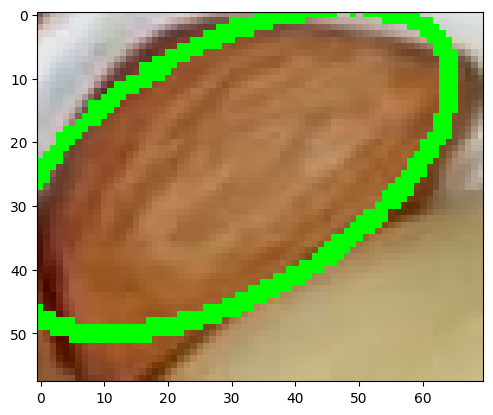

In [23]:
# Convert the contour to a format suitable for cv2.fitEllipse
contour_points = contours[0].reshape(-1, 2)

# Fit an ellipse to the contour points
ellipse = cv2.fitEllipse(contour_points)

# Calculate the scaling factor to shrink the ellipse
scale_factor = 0.8  # Adjust this factor as needed

# Scale down the ellipse dimensions
center, axes, angle = ellipse
scaled_axes = (axes[0] * scale_factor, axes[1] * scale_factor)
scaled_ellipse = (center, scaled_axes, angle)

# Draw the scaled ellipse on the image
ellipse_image = np.array(crop).copy()
cv2.ellipse(ellipse_image, scaled_ellipse, (0, 255, 0), 2)

# Display the image with the fitted ellipse
plt.imshow(ellipse_image)
plt.show()

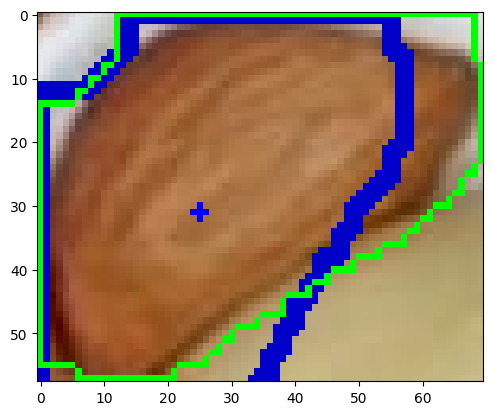

Largest chord length: 0


In [28]:
def point_on_line(point1, point2, point3, tolerance=1e-6):
    x1, y1 = point1
    x2, y2 = point2
    x3, y3 = point3

    if x1 == x2:  # Vertical line
        return abs(x3 - x1) < tolerance
    else:
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        return abs(y3 - (slope * x3 + intercept)) < tolerance


# Find the center of the mask
mask_center = np.mean(np.argwhere(mask), axis=0).astype(int)
mask_center = tuple(mask_center)  # Reverse to get (x, y) format

padded_mask = np.pad(mask_resized, pad_width=1, mode="constant", constant_values=0)
kernel = np.ones((3, 3), dtype=np.uint8)  # Kernel for erosion
eroded = cv2.erode(padded_mask, kernel, iterations=1)  # Erode the mask
border = (padded_mask - eroded)[
    1:-1, 1:-1
]  # Subtract eroded mask from the original mask

border_points = [tuple(point) for point in np.argwhere(border)]

chord_image = np.array(crop).copy()

# Calculate the maximum distance between any two points on the contour that pass through the center
# Find the closest point on the contour to the opposite point
max_distance = 0
point1, point2 = None, None
for i in range(len(border_points)):
    point1 = border_points[i]
    # line = np.arravf([mask_center, point1])
    cv2.circle(chord_image, point1, 1, (0, 0, 200), -1)
    """
    for j in range(len(contour_points)):
        if i == j:
            continue
        point2 = contour_points[j]
        

        if point_on_line(point1, point2, mask_center, 1):
            distance = np.linalg.norm(point1 - point2)
            
            if distance > max_distance:
                max_distance = distance
                max_point1, max_point2 = point1, point2
                cv2.line(chord_image, max_point1, max_point2, (255, 0, 0), 2)
    """


# cv2.line(chord_image, point1, point2, (255, 0, 0), 1)
# Ensure the points are in the correct format for OpenCV


# Draw the largest chord on the image
# cv2.line(chord_image, max_point1, max_point2, (255, 0, 0), 2)
# cv2.line(chord_image, point1, point2, (255, 0, 0), 2)

# Draw the original contour on the image
cv2.drawContours(chord_image, contours, 0, (0, 255, 0), 1)

# Draw the center point on the image
cv2.circle(chord_image, mask_center, 1, (0, 0, 255), -1)

# Display the image with the largest chord
plt.imshow(chord_image)
plt.show()

# Print the largest chord length
print(f"Largest chord length: {max_distance}")